# Speech2Face
We use facial tracking data from an iPhone X in combination with speech recordings to generate face movement, especially mouth movement of a 3D avatar from pure audio using a convolutional encoder decoder network.

These are some examples of 3D face models in blender that can be used as avatars:

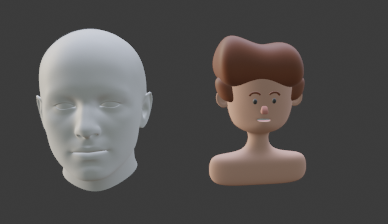

They need to have all 61 blendshapes from Apple's ARKit https://developer.apple.com/documentation/arkit/arfaceanchor/blendshapelocation
We have to animate all of them by our own in a way that we can do this:

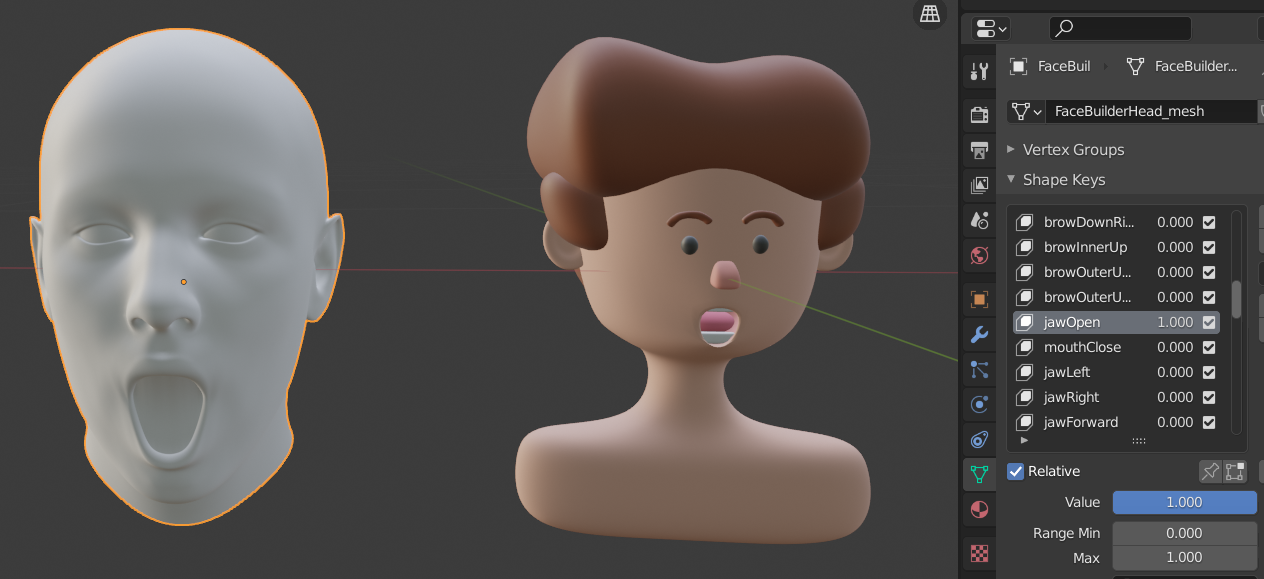

This is some example facial tracking data (.csv) from an iPhone X:

|Timecode       |eyeBlinkRight|eyeLookDownRight|eyeLookInRight|eyeLookOutRight|eyeLookUpRight|eyeSquintRight
|---------------|-------------|----------------|--------------|---------------|--------------|--------------
|59:13:52:59.348|0.1013290510 |0.1596338004    |0.1076218560  |0.0000000000   |0.0000000000  |0.3144486248  
|59:13:53:00.349|0.1013895273 |0.1574737132    |0.1091660857  |0.0000000000   |0.0000000000  |0.3172881901  
|59:13:53:01.350|0.1013020501 |0.1559140831    |0.1076435745  |0.0000000000   |0.0000000000  |0.3202917874  
|59:13:53:02.351|0.1008754969 |0.1512078792    |0.1091974601  |0.0000000000   |0.0000000000  |0.3236146867  
|59:13:53:03.352|0.1005020216 |0.1473215073    |0.1103498563  |0.0000000000   |0.0000000000  |0.3284000158  
|59:13:53:04.353|0.1000730470 |0.1447293609    |0.1100772992  |0.0000000000   |0.0000000000  |0.3334074020  
|59:13:53:05.354|0.0994871929 |0.1418033093    |0.1067825481  |0.0000000000   |0.0000000000  |0.3369660079  


We can prepare the data using this script:

In [ ]:
'''
import csv
import numpy as np
import os

face_fps = 24

def prepareBlend(path):
  filename, _ = os.path.splitext(path)
  header = []
  frames = []
  with open(path) as csvfile:
    reader = csv.reader(csvfile)
    header = next(reader)[2:] # get header
    curr_sec = 0
    block = []
    for row in reader:
      sec = row[0].split(":")[2]
      if curr_sec == 0: # group frames into 1 second blocks with varying sizes
        curr_sec = sec
      
      if curr_sec != sec:
        idx = np.round(np.linspace(0, len(block)-1, face_fps)).astype(int) # lower fps to 24 e.g. take 24 evenly spaced items out of block
        for i in idx:
          frames.append(block[i])
        block = []
        curr_sec = sec

      data = row[2:] # remove first two columns (timecode and num blendshapes)
      data = [float(string) for string in data] # convert string to float
      block.append(data)

  #write again
  with open(filename + "-prep.csv", 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(header)
    for row in frames:
      writer.writerow(row)

# With all folders
path = '...'
for dir in os.listdir(path):
  for file in os.listdir(path + dir):
    filepath = path + dir + "/" + file
    if file.endswith("csv") and "-prep" not in file:
      prepareBlend(filepath)
'''

'\nimport csv\nimport numpy as np\nimport os\n\nface_fps = 24\n\ndef prepareBlend(path):\n  filename, _ = os.path.splitext(path)\n  header = []\n  frames = []\n  with open(path) as csvfile:\n    reader = csv.reader(csvfile)\n    header = next(reader)[2:] # get header\n    curr_sec = 0\n    block = []\n    for row in reader:\n      sec = row[0].split(":")[2]\n      if curr_sec == 0: # group frames into 1 second blocks with varying sizes\n        curr_sec = sec\n      \n      if curr_sec != sec:\n        idx = np.round(np.linspace(0, len(block)-1, face_fps)).astype(int) # lower fps to 24 e.g. take 24 evenly spaced items out of block\n        for i in idx:\n          frames.append(block[i])\n        block = []\n        curr_sec = sec\n\n      data = row[2:] # remove first two columns (timecode and num blendshapes)\n      data = [float(string) for string in data] # convert string to float\n      block.append(data)\n\n  #write again\n  with open(filename + "-prep.csv", \'w\', newline=\'\') 

We can then import this .csv into blender on a model as keyframes with this python script:

In [ ]:
'''
import bpy
import os
import csv
import numpy as np

from bpy.props import StringProperty, BoolProperty
from bpy_extras.io_utils import ImportHelper
from bpy.types import Operator


class OT_TestOpenFilebrowser(Operator, ImportHelper):

    bl_idname = "test.open_filebrowser"
    bl_label = "Open the file browser (yay)"
    
    filter_glob: StringProperty(
        default='*.csv',
        options={'HIDDEN'}
    )
    
    some_boolean: BoolProperty(
        name='Do a thing',
        description='Do a thing with the file you\'ve selected',
        default=True,
    )

    def execute(self, context):
        """Do something with the selected file(s)."""

        filename, extension = os.path.splitext(self.filepath)
                
        obj = bpy.context.selected_objects[0]
        scene = bpy.context.scene
        fps = scene.render.fps
        start = scene.frame_current
        
        frame = start
        keyframes = []
        with open(self.filepath, mode='r') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                keyframes.append(row)
                
        blendshapes = keyframes.pop(0)
        
        for row in keyframes:
            c = 0
            for col in row:
                blendshape = blendshapes[c]
                if blendshape in obj.data.shape_keys.key_blocks:
                    obj.data.shape_keys.key_blocks[blendshape].value = float(col)
                    obj.data.shape_keys.key_blocks[blendshape].keyframe_insert(data_path="value", frame=frame)
                c += 1
            frame += 1
            
        return {'FINISHED'}


def register():
    bpy.utils.register_class(OT_TestOpenFilebrowser)


def unregister():
    bpy.utils.unregister_class(OT_TestOpenFilebrowser)


if __name__ == "__main__":
    register()

    # test call
    bpy.ops.test.open_filebrowser('INVOKE_DEFAULT')
'''

'\nimport bpy\nimport os\nimport csv\nimport numpy as np\n\nfrom bpy.props import StringProperty, BoolProperty\nfrom bpy_extras.io_utils import ImportHelper\nfrom bpy.types import Operator\n\n\nclass OT_TestOpenFilebrowser(Operator, ImportHelper):\n\n    bl_idname = "test.open_filebrowser"\n    bl_label = "Open the file browser (yay)"\n    \n    filter_glob: StringProperty(\n        default=\'*.csv\',\n        options={\'HIDDEN\'}\n    )\n    \n    some_boolean: BoolProperty(\n        name=\'Do a thing\',\n        description=\'Do a thing with the file you\'ve selected\',\n        default=True,\n    )\n\n    def execute(self, context):\n        """Do something with the selected file(s)."""\n\n        filename, extension = os.path.splitext(self.filepath)\n                \n        obj = bpy.context.selected_objects[0]\n        scene = bpy.context.scene\n        fps = scene.render.fps\n        start = scene.frame_current\n        \n        frame = start\n        keyframes = []\n        w

Now we can set up our deep learning network. But first we need some train, validation and test data, which can be collected by simultaneously recording face tracking data and audio while reading some text. I uploaded my recordings to my google drive: https://drive.google.com/drive/folders/12Sfv8f59r-VdRrjIKOHo11Q45cLTlwth?usp=sharing

Because speech sounds do not occur in isolation and do not have a one-to-one mapping to characters, we can capture the effects of coarticulation (the articulation of one sound influencing the articulation of another) by training the network on overlapping windows of audio data that captures sound from before and after the current time index.

So let's load the data and prepare it e.g. convert the WAV files to MFCC's, lower the FPS for the face data, convert everything to a neat format, concatenate it and slide a window over it to generate 6 frames (0.25 sec) long samples. "Depending on the data sampling rate, we recommend 26 cepstral features for 16,000 Hz and 13 cepstral features for 8,000 hz." - https://zhuanlan.zhihu.com/p/28274740

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install python_speech_features

In [ ]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from python_speech_features import mfcc
import librosa
import scipy.io.wavfile as wavfile
import cv2

face_fps = 24
audio_fps = 8000

face_size = 61
audio_size = 13

face_sample_size = int(face_fps / 4) # 250ms
audio_sample_size = int(audio_fps / 4) # 250ms

#face_sample_size = int(face_fps / 2) # 500ms
#audio_sample_size = int(audio_fps / 2) # 500ms

#face_sample_size = face_fps # 1000ms
#audio_sample_size = audio_fps # 1000ms

def slideWindow(a, size, step):
  b = []
  i = 0
  pos = 0
  while pos + size < len(a):
    pos = int(i  * step)
    b.append(a[pos : pos + size])
    i+=1
  return b

def getBlend(path, size = face_sample_size, step = 3):
  frames = []
  with open(path) as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None) # skip header
    for row in reader:
      data = [float(string) for string in row]
      frames.append(data)
  out = slideWindow(frames, size, step)
  print(path, len(out))
  return out[:-1] # last one is not full

def getAudio(path, size = audio_sample_size, step = 1000):
  out = []
  (rate, sig) = wavfile.read(path)
  samples = slideWindow(sig, size, step)
  for sample in samples:
    out.append(mfcc(sample, rate))
  print(path, rate, len(out))
  return out[:-1] # last one is not full

In [ ]:
path = '/content/drive/MyDrive/Speech2Face/'
face = []
audio = []

for dir in os.listdir(path):
  if dir != 'test':
    f = []
    a = []
    for file in os.listdir(path + dir):
      filepath = path + dir + "/" + file
      if file.endswith("-prep.csv"):
        f = getBlend(filepath)
      elif file.endswith(".wav"):
        a = getAudio(filepath)
    m = min(len(f), len(a)) # bring to same length
    face.extend(f[:m])
    audio.extend(a[:m])

print(np.shape(face), np.shape(audio))

/content/drive/MyDrive/Speech2Face/20210425_MySlate_25/MySlate_25_iPhone_von_Frank-converted.wav 8000 1024
/content/drive/MyDrive/Speech2Face/20210425_MySlate_25/MySlate_25_iPhone_von_Frank-prep.csv 1023
/content/drive/MyDrive/Speech2Face/20210425_MySlate_28/MySlate_28_iPhone_von_Frank-converted.wav 8000 630
/content/drive/MyDrive/Speech2Face/20210425_MySlate_28/MySlate_28_iPhone_von_Frank-prep.csv 626
/content/drive/MyDrive/Speech2Face/20210405_MySlate_17/MySlate_17_iPhone_von_Frank-converted.wav 8000 706
/content/drive/MyDrive/Speech2Face/20210405_MySlate_17/MySlate_17_iPhone_von_Frank-prep.csv 703
/content/drive/MyDrive/Speech2Face/20210405_MySlate_22/MySlate_22_iPhone_von_Frank-converted.wav 8000 431
/content/drive/MyDrive/Speech2Face/20210405_MySlate_22/MySlate_22_iPhone_von_Frank-prep.csv 431
/content/drive/MyDrive/Speech2Face/20210405_MySlate_23/MySlate_23_iPhone_von_Frank-converted.wav 8000 511
/content/drive/MyDrive/Speech2Face/20210405_MySlate_23/MySlate_23_iPhone_von_Frank-p

Now we select the most important features.

In [ ]:
face_sel = np.concatenate(face)[:, [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]]
face = slideWindow(face_sel, size=face_sample_size, step=face_sample_size)

Normalize.

In [ ]:
face_size = np.shape(face)[2]
audio_feature_sample_size = len(audio[0])
print(np.shape(face), face_size)

audio = (audio - np.min(audio)) / np.ptp(audio)
face = (face - np.min(face)) / np.ptp(face)

(34836, 6, 23) 23


Let's plot a bit of that. (note that x is time and y are the features)

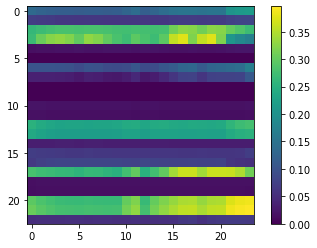

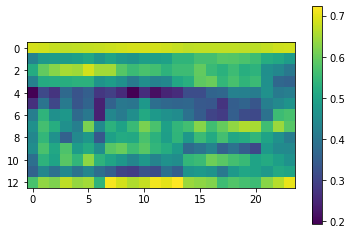

In [ ]:
plt.imshow(np.transpose(np.concatenate(face[1010:1014])))
plt.colorbar()
plt.show()

plt.imshow(np.transpose(audio[1010]))
plt.colorbar()
plt.show()

We will use Mel-frequency cepstral coefficients (MFCC) values as input for the **audio encoder** and the blendshape data as output from the **face decoder**.

We will try three kinds of networks:
1. First we try a complete encoder-decoder convolutional neural network, with Freq->Time convolution or VGG, we could also try ResNet50

2. Then we will try a complete sequence to sequence recurrent neural network, with LSTM or GRU

3. And then we will try a combination of both, where we first extract the features using a convolutional encoder (Freq->Time/VGG) and then use a recurrent layer (LSTM/GRU) for sequential output. "Several key improvements that have been made by the Microsoft team and other researchers in the past 4 years include: ...using convolutional neural nets (CNNs) for extracting features from the audio"


Hyperparamters to try:
- Different sizes
- Different pooling
- Dropout
- BatchNorm

Remember we have an input shape of (25, 13) so a sequence of 25 vectors with 13 features each. And we have an output shape of (6, 61) so a sequence of 6 vectors with 61 features each.

- [Pham et al. (2017)](https://arxiv.org/pdf/1710.00920.pdf)
- [Lamaludin et al. (2019)](https://link.springer.com/article/10.1007/s11263-019-01150-y)
- [Hershey et al. (2017)](https://arxiv.org/pdf/1609.09430.pdf)
- [Xiong et al. (2016)](https://arxiv.org/pdf/1609.03528.pdf)

# Erste Methode

* conv -> pool: good
* conv -> norm -> dropout -> pool: bad (lange streifen ohne detail)
* conv -> norm -> pool: bad (stückelig, kein detail)
* conv -> dropout -> pool: bad (lange streifen ohne detail)

In [ ]:
import tensorflow as tf

In [ ]:
batch_size = 32
epochs = 25

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(24, 13, 1)),
  tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 13), activation="relu", padding='same'),
  #tf.keras.layers.BatchNormalization(),
  #tf.keras.layers.Dropout(0.2),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),

  tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 13), activation="relu", padding="same"),
  #tf.keras.layers.BatchNormalization(),
  #tf.keras.layers.Dropout(0.2),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),

  tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 13), activation="relu", padding="same"),
  #tf.keras.layers.BatchNormalization(),
  #tf.keras.layers.Dropout(0.2),
  tf.keras.layers.MaxPooling2D(pool_size=(1,2)),

  tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 6), activation="relu", padding="same"),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.MaxPooling2D(pool_size=(1,2)),

  tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same"),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.MaxPooling2D(pool_size=(1, 2)),

  tf.keras.layers.Reshape((6, 64)),
  tf.keras.layers.Conv1D(23, 6, activation="tanh", padding="same"),
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 24, 13, 16)        640       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 13, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 13, 32)        20000     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 13, 32)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 13, 64)         79936     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 6, 6, 64)         

In [ ]:
encoder_input = np.expand_dims(audio, axis=3)
decoder_output = np.expand_dims(face, axis=3)

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.005)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(encoder_input, decoder_output, batch_size=batch_size, epochs=epochs,
                    validation_split=0.2, callbacks=[reduce_lr, es_callback])
model.save('/results/speech2face_cnn')

Epoch 1/25
871/871 [==============================] - 85s 96ms/step - loss: 0.0034 - val_loss: 0.0044
Epoch 2/25
871/871 [==============================] - 83s 96ms/step - loss: 0.0032 - val_loss: 0.0042
Epoch 3/25
871/871 [==============================] - 84s 97ms/step - loss: 0.0031 - val_loss: 0.0040
Epoch 4/25
871/871 [==============================] - 84s 96ms/step - loss: 0.0030 - val_loss: 0.0038
Epoch 5/25
871/871 [==============================] - 83s 96ms/step - loss: 0.0030 - val_loss: 0.0039
Epoch 6/25
871/871 [==============================] - 83s 95ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 7/25
871/871 [==============================] - 83s 96ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 8/25
871/871 [==============================] - 83s 96ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 9/25
871/871 [==============================] - 83s 95ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 10/25
871/871 [==============================] - 84s 96ms/step - loss: 0.002

dict_keys(['loss', 'val_loss', 'lr'])


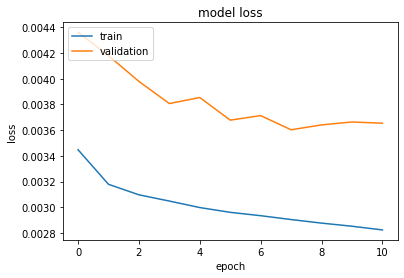

In [ ]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

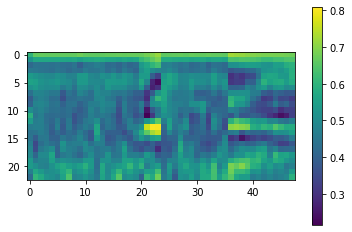

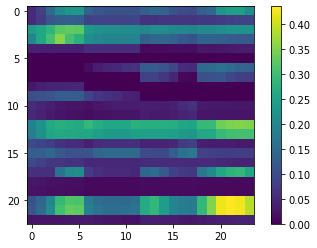

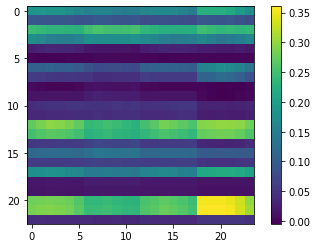

In [ ]:
start = 0
num = 10

audio_stitched = np.asarray(audio[start*num:(start+batch_size)*num:8*num])
decoded_sequence = model.predict(np.expand_dims(audio_stitched, axis=3))

ai = cv2.resize(np.concatenate(audio_stitched), dsize=(face_size, 48), interpolation=cv2.INTER_CUBIC)
plt.imshow(np.transpose(ai))
plt.colorbar()
plt.show()

plt.imshow(np.transpose(np.concatenate(face[start*num:(start+batch_size)*num:8*num])))
plt.colorbar()
plt.show()

plt.imshow(np.transpose(np.concatenate(decoded_sequence)))
plt.colorbar()
plt.show()

Try test data.

In [ ]:
test_audio = '/content/drive/MyDrive/Speech2Face/test/test.wav'
test_face = '/content/drive/MyDrive/Speech2Face/test/test-prep.csv'

a = getAudio(test_audio, step = audio_sample_size) # no overlap
f = getBlend(test_face, step = face_sample_size) # no overlap

m = min(len(f), len(a)) # bring to same length
test_output = np.asarray(f[:m])
test_input = np.asarray(a[:m])

#normalize
test_input = (test_input - np.min(test_input)) / np.ptp(test_input)
test_output = (test_output - np.min(test_output)) / np.ptp(test_output)
                 
print(np.shape(test_input), np.shape(test_output))

/content/drive/MyDrive/Speech2Face/test/test.wav 8000 23
/content/drive/MyDrive/Speech2Face/test/test-prep.csv 19
(18, 24, 13) (18, 6, 61)


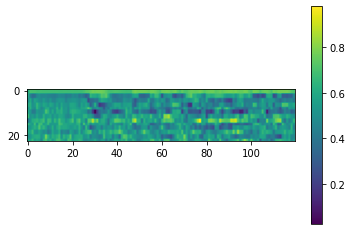

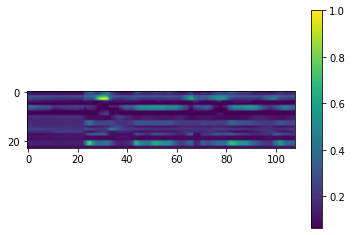

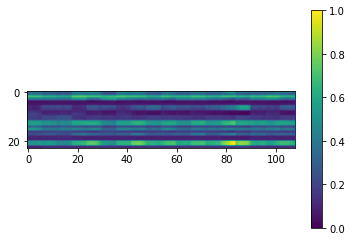

In [ ]:
decoded = model.predict(np.expand_dims(test_input, axis=3))
#decoded = (decoded - np.min(decoded)) / np.ptp(decoded)

ti = cv2.resize(np.concatenate(test_input), dsize=(face_size, 120), interpolation=cv2.INTER_NEAREST)
plt.imshow(np.transpose(ti))
plt.colorbar()
plt.show()

#transform
#test_output = face_sel.transform(np.concatenate(test_output))
test_output = np.concatenate(test_output)[:, [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]]
plt.imshow(np.transpose(test_output))
plt.colorbar()
plt.show()

plt.imshow(np.transpose(np.concatenate(decoded)))
plt.colorbar()
plt.show()

In [ ]:
!zip -r /results/speech2face_cnn.zip /results/speech2face_cnn/

updating: results/speech2face_cnn/ (stored 0%)
updating: results/speech2face_cnn/saved_model.pb (deflated 90%)
updating: results/speech2face_cnn/variables/ (stored 0%)
updating: results/speech2face_cnn/variables/variables.index (deflated 68%)
updating: results/speech2face_cnn/variables/variables.data-00000-of-00001 (deflated 17%)
updating: results/speech2face_cnn/assets/ (stored 0%)
updating: results/speech2face_cnn/keras_metadata.pb (deflated 93%)
